# Quick start with aiida_castep

## Introduction

`aiida-castep` is a plugin to interface CASTEP with [AiiDA](www.aiida.net) (Automated Interactive Infrastructure and Database for Computational Science).  
It is quite complicated to explain what AiiDA is, but here are some key benefits:
* Prepare/generate inputs for CASTEP in python
* Job submission/state monitoring/retrieving is handled by AiiDA - no more ssh/rsync/sbatch/squeue/qsub/qstat/....
* **All** inputs and outputs of **every** calculation are stored in a graph-like database, preserving the provenance
* Workflow automation

In [1]:
!echo $AIIDA_PATH

/home/bonan/aiida_envs/aiida-1.0.0


## Basic concepts
AiiDA stores everything as `Node` and connect them by *link* (i.e a graph database).
There are two type of nodes `Calculation` and `Data`. 
### Below is an exmaple of the provenance graph of a `CastepSpectralCalculation`
We first do a geometry optimisation calculation labeled as **'Si RELAX'** and the output structure is used as the 
input of the subsequent spectral calculation **'Si BS'**. The model is also reused as indicated by the `parent_calc_folder` link. In addition, an extra set of kpoints is used as the input for the bandstructure calculation as indicated by the `spectral_kpoints` link.

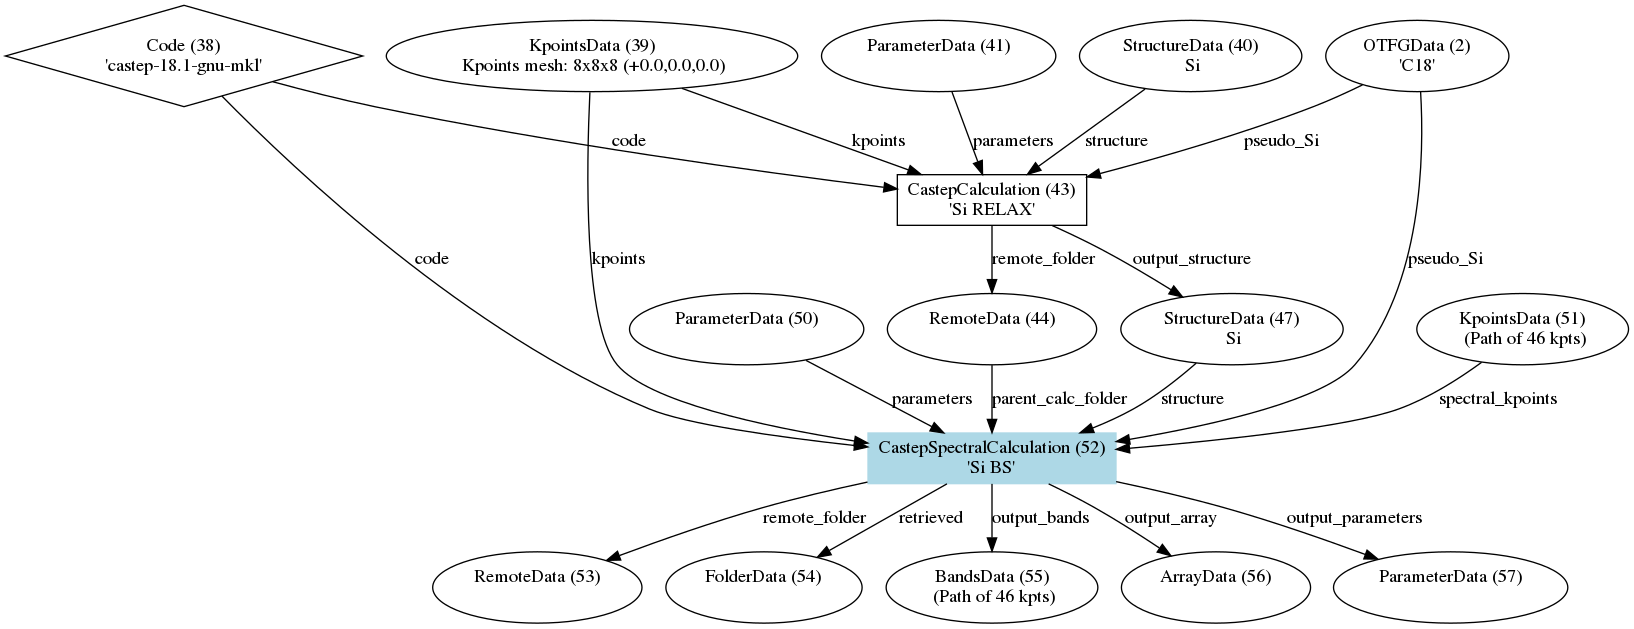

In [2]:
# A exmaple of the provenance graph of a CastepSpectralCalculation
from __future__ import print_function
from IPython.display import Image
Image("./Si_bs_example.png")

The calculations (square) take data nodes (circle) as the input and create output data nodes.
There is also a `Code` node which represents the code that is used to conduct the calculation, i.e the CASTEP executable on the remote cluster.  

## Preparing a CASTEP calculation
Here are the essential parts of a CASTEP calculations and their representation in AiiDA:
* A input structure - `StructureData`
* A set of kpoints - `KpointsData`
* A set of pseudopotentials  - `OTFGData` or `UspData` or even `UpfData`
* The parameters for calculations, e.g keys in the `param` and `cell` files - `Dict`

Below is a walk-through of the steps to create a single point calculation using the basic `CastepCalculation` class.

In [3]:
import numpy as np
from pprint import pprint
# Load the AiiDA environment
%aiida

/home/bonan/miniconda3/envs/aiida-1.0.0b1/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Loaded AiiDA DB environment.

## Example CASTEP run - silicon bandstructure
This is taken from the online tutorial. Using this as an example input
we define a similar single point calculation with `aiida-castep`.

In [4]:
!cat 'bandstructure/silicon/Si2.cell' | grep -v -e "^!"

%block lattice_cart
2.6954645 2.6954645 0.0 
2.6954645 0.0       2.6954645
0.0       2.6954645 2.6954645
%endblock lattice_cart
%block positions_frac
Si 0.00 0.00 0.00
Si 0.25 0.25 0.25
%endblock positions_frac
symmetry_generate
%block species_pot
Si Si_00.usp
%endblock species_pot
kpoint_mp_grid 4 4 4
%block bs_kpoint_path 
0.5 0.25 0.75    ! W
0.5 0.5 0.5      ! L
0.0 0.0  0.0     ! Gamma
0.5 0.0 0.5      ! X
0.5 0.25 0.75    ! W
0.375 0.375 0.75 ! K
%endblock bs_kpoint_path 


In [5]:
!cat 'bandstructure/silicon/Si2.param' | grep -v -e "^!"

task		bandstructure ! The TASK keyword instructs CASTEP what to do
xc_functional   LDA           ! Which exchange-correlation functional to use.
basis_precision MEDIUM        ! Choose high cut-off COARSE/MEDIUM/FINE/PRECISE
fix_occupancy   true          ! Treat the system as an insulator
opt_strategy    speed         ! Choose algorithms for best speed at expense of memory.
num_dump_cycles 0             ! Don't write unwanted ".wvfn" files.
write_formatted_density TRUE  ! Write out a density file that we can view using (e.g.) Jmol.


### Define the structure by creating the `StructureData` node

In [6]:
# Define the structure
from aiida.plugins import DataFactory
StructureData = DataFactory('structure')
silicon = StructureData()
r_unit = 2.6954645
silicon.set_cell(np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]) * r_unit)
silicon.append_atom(symbols=["Si"], position=[0, 0, 0])
silicon.append_atom(symbols=["Si"], position=[r_unit * 0.5] * 3)
silicon.label = "Si"
silicon.description = "A silicon structure"

In [7]:
# You can also use ase.Atoms object to create the StructureData
from ase import Atoms
silicon_atoms = Atoms('Si2', cell=silicon.cell, scaled_positions=((0, 0, 0), (0.25, 0.25, 0.25)))
silicon_from_atoms = StructureData(ase=silicon_atoms)

In [8]:
# You can also convent the StructureData back to ase.Atoms
silicon_atoms_2 = silicon_from_atoms.get_ase()
silicon_atoms_2 == silicon_atoms

True

### Define the parameters by creating the `Dict` node
All key-value pairs and blocks are stored in a nested dictionary hold by a `Dict` node

In [9]:
# Define a dictionary to store the parameters of the calculations
Dict = DataFactory('dict')
param_dict = {
    # Notice that the keywords are group into two sub-dictionaries
    # just like you would do when preparing the inputs by hand
    "CELL":{
        "symmetry_generate": True,
        "snap_to_symmetry": True,
        # Pass a list of string to set a BLOCK inputs
        #"cell_constraints":
        #["0 0 0", "0 0 0"]
    },
    "PARAM":{
        "task": "singlepoint",
        "basis_precision": "medium",
        "fix_occupancy": True,   # Use bool type to make it easy for querying
        "opt_strategy": "speed",
        "num_dump_cycles": 0,  
        "write_formatted_density": True
    }}
# We need to create a Dict node that holds the dictionary
param = Dict(dict=param_dict)

In [10]:
# You can acceess the stored data
pprint(param.get_dict())

# You can also reset the data in the Dict node
param_dict["PARAM"].update(opt_strategy="memory")
param.set_dict(param_dict)

{'CELL': {'snap_to_symmetry': True, 'symmetry_generate': True},
 'PARAM': {'basis_precision': 'medium',
           'fix_occupancy': True,
           'num_dump_cycles': 0,
           'opt_strategy': 'speed',
           'task': 'singlepoint',
           'write_formatted_density': True}}


### Define the kpoints with the `KpointsData` node

In [11]:
KpointsData = DataFactory('array.kpoints')
# You can define kpoints explicitly
kpoints = KpointsData()
# Use gamma and 0.25, 0.25, 0.25
kpoints.set_kpoints(((0., 0., 0), (0.25, 0.25, 0.25)), weights=[0.5, 0.5])
pprint(kpoints.get_kpoints(also_weights=True))

(array([[0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25]]), array([0.5, 0.5]))


In [12]:
# More commonly, we want to use a grid (mesh) of the kpoints
kpoints = KpointsData()
kpoints.set_kpoints_mesh((4, 4, 4), offset=(0,0,0))
print(kpoints.get_kpoints_mesh())

([4, 4, 4], [0.0, 0.0, 0.0])


### Define the pseudopotentials

In [13]:
from aiida_castep.tests.dbtests.conftest import CastepTestApp

In [14]:
app = CastepTestApp(None, "/tmp")

In [15]:
from aiida_castep.data.otfg import OTFGData
from aiida_castep.data.usp import UspData
# Explicitly define the OTFG string
si_c18 = OTFGData(otfg_entry="Si 3|1.8|5|6|7|30:31:32")
# Alternatively you can define explicitly the file to be used
#si_usp = UspData(file="/home/max/MS61_00/Si_00.usp")

In [16]:
c9 = app.c9_otfg

### Prepare the `CastepCalculation` node

In [17]:
# Finally, we define the calculations itself
#code = Code.get_from_string("castep-18.1@localhost")  # Load the Code by label and location
from aiida_castep.calculations.castep import CastepCalculation

In [18]:
builder = CastepCalculation.get_builder()

In [19]:
#comp = Computer('localhost', 'localhost', transport_type='local', scheduler_type='direct')
#comp.store()
comp = app.localhost

In [20]:
code = app.code_echo

In [22]:
# Create the real CASTEP Code
castep_18 = Code(remote_computer_exec=(app.localhost, "/home/bonan/appdir/CASTEP-18.1/bin/linux_x86_64_gfortran7.0/castep.serial"), input_plugin_name='castep.castep')
castep_mock = Code((app.localhost, "/home/bonan/miniconda3/envs/aiida-1.0.0b1/bin/castep.mock"), input_plugin_name='castep.castep')

In [23]:
builder.structure = silicon
builder.parameters = param
builder.kpoints = kpoints
#builder.code = code
#builder.code = castep_18
builder.code = castep_mock
builder.pseudos = {'Si': c9}
builder.metadata.options.withmpi = False

In [24]:
# Select the SSSP potential in the UPF format
# NOTE: xc_functional may be inconsisent when using file based potentials
# calc.use_pseudos_from_family('SSSP_efficiency_v1.0')

In [25]:
builder.metadata.options.resources = {'num_machines': 1, 'tot_num_mpiprocs': 2}
builder.metadata.options.max_wallclock_seconds = 600
builder.metadata.label = "Si SINGLEPOINT"
builder.metadata.description = 'A Example CASTEP calculation for silicon'

In [26]:
def d2attr(d, b):
    for k, v in d.items():
        b.__setattr__(k, v)

In [27]:
from aiida.engine import run_get_node
from aiida.engine import Process

In [42]:
results, calcjob  = run_get_node(builder)

In [32]:
calcjob.get_option('seedname')

'aiida'

In [37]:
import importlib
from aiida_castep.utils import mock
importlib.reload(mock)

<module 'aiida_castep.utils.mock' from '/home/bonan/aiida_envs/aiida-1.0.0/aiida-castep/aiida_castep/utils/mock.py'>

## Transverse the graph
Demostrate how to follow the links to get the input and output of a calculation

In [44]:
lns = calcjob.get_incoming()  # This is an link manager

In [45]:
# A link triple is a object contains the link label, vertex of the link
link = lns.first()
print(f"Link label: {link.link_label}")
print(f"Link node: {link.node}")
print(f"Link type: {link.link_type}")

Link label: code
Link node: Remote code '' on localhost, pk: 22, uuid: 27e14f97-96e8-4222-8a19-1d469516f12e
Link type: LinkType.INPUT_CALC


In [46]:
# Get the node by the link label
print(lns.get_node_by_label('structure').__repr__())
print(lns.get_node_by_label('parameters').__repr__())

<StructureData: uuid: bd114812-0582-46a7-9a4c-7d3458bb4742 (pk: 19)>
<Dict: uuid: e433bb4d-ec7c-4045-8c61-59132903203c (pk: 20)>


In [47]:
# Link pair includes link type and link label
lns.all_link_pairs()

[LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='code'),
 LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='kpoints'),
 LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='parameters'),
 LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='structure'),
 LinkPair(link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='pseudos_Si')]

In [48]:
# Link triples also include nodes
lns.link_triples

[LinkTriple(node=<Code: Remote code '' on localhost, pk: 22, uuid: 27e14f97-96e8-4222-8a19-1d469516f12e>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='code'),
 LinkTriple(node=<KpointsData: uuid: 33f3c197-9b18-4d2c-971b-74dc019a9429 (pk: 21)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='kpoints'),
 LinkTriple(node=<Dict: uuid: e433bb4d-ec7c-4045-8c61-59132903203c (pk: 20)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='parameters'),
 LinkTriple(node=<StructureData: uuid: bd114812-0582-46a7-9a4c-7d3458bb4742 (pk: 19)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='structure'),
 LinkTriple(node=<OTFGData: uuid: 89ce705d-bcc7-4d7e-8bab-7ff917411393 (pk: 1)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='pseudos_Si')]

## Monitor the run

In [54]:
# Monitor the status
!verdi process list -a
#!squeue

|/home/bonan/miniconda3/envs/aiida-1.0.0b1/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
  PK  Created    State           Process label      Process status
----  ---------  --------------  -----------------  ----------------------------------
   7  10h ago    ⏹ Finished [0]  CastepCalculation
  13  10h ago    ⏵ Waiting       CastepCalculation  Waiting for transport task: submit
  16  9h ago     ⏹ Created       CastepCalculation
  17  9h ago     ⏹ Created       CastepCalculation
  23  9h ago     ⏹ Finished [0]  CastepCalculation
  29  9h ago     ⏹ Finished [0]  CastepCalculation

Total results: 6

Info: last time an entry changed state: 9h ago (at 00:10:42 on 2019-04-04)


In [55]:
# The to access the output
! verdi calcjob outputcat 29

|/home/bonan/miniconda3/envs/aiida-1.0.0b1/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
 +-------------------------------------------------+
 |                                                 |
 |      CCC   AA    SSS  TTTTT  EEEEE  PPPP        |
 |     C     A  A  S       T    E      P   P       |
 |     C     AAAA   SS     T    EEE    PPPP        |
 |     C     A  A     S    T    E      P           |
 |      CCC  A  A  SSS     T    EEEEE  P           |
 |                                                 |
 +-------------------------------------------------+
 |                                                 |
 | Welcome to Academic Release CASTEP version 18.1 |          
 | Ab Initio Total Energy Program                 

In [61]:
calcjob.get_state()

In [65]:
# Get the State of the calculation in python
print("State: " + str(calcjob.process_state))
# Or 
calcjob.is_finished

State: ProcessState.FINISHED


True

## Access the results

In [68]:
# A Dict node is created containing some of the parsed results
calcjob.outputs.output_parameters.get_dict()

{'total_energy': -337.9095600861,
 'parser_info': 'AiiDA CASTEP basic Parser v0.2.4',
 'parser_warnings': [],
 'geom_unconverged': None,
 'total_time': 6.72,
 'finalisation_time': 0.02,
 'calculation_time': 2.89,
 'initialisation_time': 3.81,
 'pseudo_pots': {'Si': '3|1.8|5|6|7|30:31:32'},
 'cell_constraints': '1 1 1 0 0 0',
 'space_group': '227: Fd-3m, F 4d 2 3 -1d',
 'point_group': '32: Oh, m-3m, 4/m -3 2/m',
 'n_kpoints': '10',
 'num_ions': 2,
 'unit_force': 'eV/A',
 'unit_energy': 'eV',
 'unit_time': 'ps',
 'unit_length': 'A',
 'castep_version': '18.1',
 'warnings': []}

In [ ]:
# Alternatively, you can access the parsed results using
calcjob.res.   # hit tab for completion

In [70]:
# To get all the outgoing links and nodes
calcjob.get_outgoing().all()

[LinkTriple(node=<Dict: uuid: 8e7bc341-d949-40fe-82d7-e3460b6665cc (pk: 34)>, link_type=<LinkType.CREATE: 'create'>, link_label='output_parameters'),
 LinkTriple(node=<ArrayData: uuid: f951a6d7-db9f-4b6d-a128-b4adcda31911 (pk: 33)>, link_type=<LinkType.CREATE: 'create'>, link_label='output_array'),
 LinkTriple(node=<BandsData: uuid: 5c7cb699-90e6-4c2f-98e4-61a453292513 (pk: 32)>, link_type=<LinkType.CREATE: 'create'>, link_label='output_bands'),
 LinkTriple(node=<FolderData: uuid: a3c9a0f4-f7d8-4d71-823c-afa145019b68 (pk: 31)>, link_type=<LinkType.CREATE: 'create'>, link_label='retrieved'),
 LinkTriple(node=<RemoteData: uuid: e06e2b8b-cea1-4f56-8dfa-527202db78a8 (pk: 30)>, link_type=<LinkType.CREATE: 'create'>, link_label='remote_folder')]

In [75]:
# Or just the nodes
calcjob.get_outgoing().all_nodes()

[<Dict: uuid: 8e7bc341-d949-40fe-82d7-e3460b6665cc (pk: 34)>,
 <ArrayData: uuid: f951a6d7-db9f-4b6d-a128-b4adcda31911 (pk: 33)>,
 <BandsData: uuid: 5c7cb699-90e6-4c2f-98e4-61a453292513 (pk: 32)>,
 <FolderData: uuid: a3c9a0f4-f7d8-4d71-823c-afa145019b68 (pk: 31)>,
 <RemoteData: uuid: e06e2b8b-cea1-4f56-8dfa-527202db78a8 (pk: 30)>]

In [76]:
# The output .castep files and others are stored in the file repository
calcjob.outputs.retrieved.list_object_names()

['_scheduler-stderr.txt',
 '_scheduler-stdout.txt',
 'aiida.bands',
 'aiida.castep',
 'aiida.den_fmt']

In [79]:
# To quickly check the output file
!echo '{calcjob.outputs.retrieved.get_object_content('aiida.castep')}' | grep 'Final energy' 

# The parsed the total energy
print(calcjob.res.total_energy)

Final energy =  -337.9095600861     eV
-337.9095600861
